# 🛠️ MLflow Hands-On

🎯 **Our goal** is to demonstrate how to integrate **MLflow** into a *machine learning* project, showcasing its role in tracking and managing experiments efficiently.

We'll start by **fitting an initial boosting model**, logging parameters, metrics, and artifacts. Then, we'll move on to **hyperparameter optimization using Optuna**, with the entire workflow tracked and versioned through MLflow.

---------------

🛒 **Dataset**
For this project, we used the **Wholesale Customers Data Set**, available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers).

This dataset provides insights into customer spending habits across different product categories, making it a useful resource for unsupervised learning and clustering tasks.

## 📚 Importing libraries

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Modeling and Evaluation
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay)

# Optimization and Experiment Tracking
from mlflow.tracking import MlflowClient
import optuna
import mlflow

#  Utilities
import warnings
import json
import math
from datetime import datetime, timedelta

from sklearn.metrics import f1_score
import math

# Suppress Warnings
warnings.filterwarnings('ignore')

## 📥 Import dataset

In [2]:
df = pd.read_csv('Wholesale customers data.csv')
df.tail()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125
439,1,3,2787,1698,2510,65,477,52


## 🔍 Checking for missing values

In [3]:
df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

## 🎯 Declare feature vector and target variable

In [4]:
X = df.drop('Channel', axis=1)

y = df['Channel']
y.head()

0    2
1    2
2    2
3    1
4    2
Name: Channel, dtype: int64

We can see that the \$y\$ labels currently contain the values \$1\$ and \$2\$. For simplicity and easier interpretation, we will convert them to \$0\$ and \$1\$ for further analysis.

In [5]:
y[y == 2] = 0
y[y == 1] = 1

Now, I will convert the dataset into an optimized data structure called **Dmatrix** that XGBoost supports and gives it acclaimed performance and efficiency gains

In [6]:
data_dmatrix = xgb.DMatrix(data=X, label=y)

## ✂️ Split data into separate training and test set

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## 🔧 Train the XGBoost Classifier

Now it's time to train our **XGBoost classifier**!
Before we begin, it’s important to understand the different types of parameters that XGBoost offers. These parameters control the model’s behavior, performance, and complexity.

There are **four main categories** of parameters you should know:


### ⚙️ General parameters

These define which **booster type** to use (e.g., tree-based or linear).
Common options include:

* `gbtree` – tree-based models (default)
* `gblinear` – linear models
* `dart` – tree-based models with dropout


### 🌲 Booster parameters

These depend on the selected booster type and control the training process of individual trees or models.


### 🎯 Learning task parameters

These define the **objective function** and the type of learning task (e.g., regression, classification, ranking).

### 💻 Command line parameters

These relate to the CLI (Command Line Interface) version of XGBoost, and aren’t usually needed when using the Python API.


## 🧠 Key Parameters to know

Here are some of the most important parameters you'll likely tune:

* **`learning_rate`** – Controls the step size shrinkage to prevent overfitting. Range: `[0, 1]`.
* **`max_depth`** – Maximum depth of a tree. Deeper trees can capture more complex patterns.
* **`subsample`** – Fraction of the training data to use for each tree. Lower values can help prevent overfitting.
* **`colsample_bytree`** – Fraction of features to use for each tree. Higher values may lead to overfitting.
* **`n_estimators`** – Number of boosting rounds (i.e., trees).
* **`objective`** – Specifies the learning task and the corresponding loss function:

  * `reg:squarederror` – for regression
  * `binary:logistic` – for binary classification (probability output)
  * `reg:logistic` – for classification with decision outputs


## 🛡️ Regularization parameters

XGBoost also offers regularization to reduce model complexity and avoid overfitting:

* **`gamma`** – Minimum loss reduction required to make a split. Higher values result in fewer splits.
* **`alpha`** – L1 regularization term on weights (Lasso). Encourages sparsity.
* **`lambda`** – L2 regularization term on weights (Ridge). Adds smoothness.

Even though we're using **trees as base learners**, XGBoost also supports linear models (`gblinear`) and dropout-based trees (`dart`) via the `booster` parameter.

---

Imagine you're a data scientist, and it's time to fine-tune your machine learning model. Fortunately, after some experimentation, you’ve found that the parameter combination below delivers a satisfactory performance for your classification task.


In [8]:
params = {
    # Target function for binary classification
    'objective': 'binary:logistic',

    # Evaluation metric
    'eval_metric': 'logloss',

    # Booster type (default is 'gbtree')
    'booster': 'gbtree',

    # Learning rate (step size shrinkage)
    'learning_rate': 0.1,

    # Maximum depth of each tree
    'max_depth': 3,

    # Subsample ratio of the training instances
    'subsample': 0.8,

    # Subsample ratio of columns for each tree
    'colsample_bytree': 0.8,

    # L2 regularization term on weights (Ridge)
    'lambda': 1.0,

    # L1 regularization term on weights (Lasso)
    'alpha': 0.0}

#------------------

# Instantiate the classifier
xgb_clf = XGBClassifier(**params)

# Fit the classifier to the training data
xgb_clf.fit(X_train, y_train)
print(xgb_clf)


XGBClassifier(alpha=0.0, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1.0,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, ...)


## 🔮 Make Predictions with XGBoost Classifier

In [9]:
# make predictions on test data
y_pred = xgb_clf.predict(X_test)

## ✅ Check Accuracy Score

Accuracy:  0.8939
Precision: 0.8913
Recall:    0.9535
f1-Score:  0.9213
AUC:       0.9626


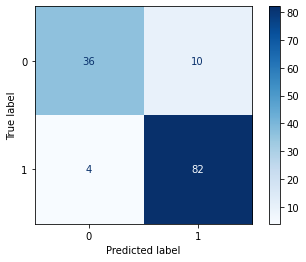

In [10]:
# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])

# Print scores
print(f'Accuracy:  {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'f1-Score:  {f1:.4f}')
print(f'AUC:       {auc:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

## 🔍 Feature importance with XGBoost

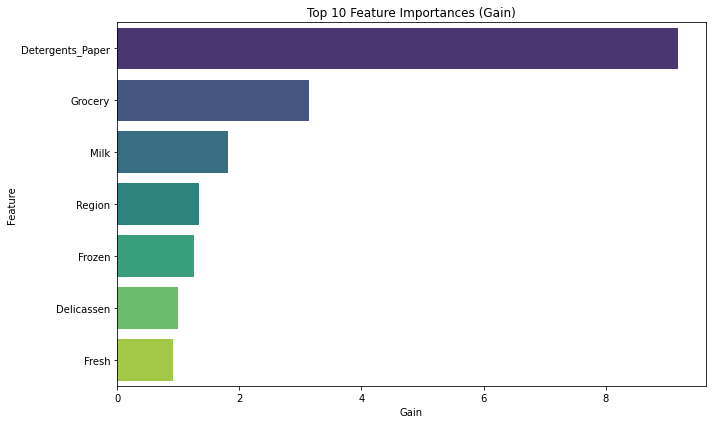

In [11]:
importances = xgb_clf.get_booster().get_score(importance_type='gain')

# Convert to DataFrame and sort
importance_df = pd.DataFrame({
    'Feature': list(importances.keys()),
    'Importance': list(importances.values())
}).sort_values(by='Importance', ascending=False)

# Optional: show only top N features
top_n = 10
importance_df = importance_df.head(top_n)

# Plot with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title(f"Top {top_n} Feature Importances (Gain)")
plt.xlabel("Gain")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


------------

📦 **Project Handoff to MLOps**

Now, imagine this is the final output of a data scientist's work. This project will be handed over to a machine learning engineer, who will be responsible for versioning the model using MLflow.

The engineer will set up experiment tracking, store the generated artifacts, monitor model performance metrics, and ensure the entire workflow is reproducible all as part of a well-structured MLOps pipeline.

🎯 **Next Step: Hyperparameter Optimization**

From this point on, we will perform hyperparameter optimization using Optuna. Meanwhile, MLflow will continue to log each experiment, allowing us to compare versions and easily identify the best set of parameters.


---------

## ⚙️ MLOps in Practice: Managing the Machine Learning Model Lifecycle

Now, we explore how **MLOps** practices help structure, automate, and scale the machine learning model lifecycle — from data preparation and model training to deployment, monitoring, and continuous improvement. We'll demonstrate how tools like **MLflow** can streamline this process and ensure reproducibility, traceability, and collaboration across teams.

## 🚀 Initializing the MLflow Server

To start the MLflow tracking server locally, follow the steps based on your environment:

---

### 🐍 **Using Anaconda**

1. Open the **Anaconda Command Prompt**  
2. Navigate to your project directory:

   ```bash
   cd your-project-path

3. Run the MLflow server:

   ```bash
   python -m mlflow server --host 127.0.0.1 --port 8282


### 💻 **Using VS Code**

1. Open the **terminal** in VS Code
2. Run the command below:

   ```bash
   py -m mlflow server --host 127.0.0.1 --port 8282

✅ Make sure you're using the same Python environment or kernel as the one used in your notebook or training script.

-----

🛰️  Now, let's define the address of the MLflow tracking server — that is, where the experiment logs (parameters, metrics, models, etc.) will be sent and stored.

In [ ]:
mlflow.set_tracking_uri("http://127.0.0.1:8282")

Access the URL above from a new tab in your browser: [http://127.0.0.1:8282](http://127.0.0.1:8282)


## 📈 **Monitoring the Trained Model**

To properly monitor the performance of the trained model, we will generate a series of visualizations that will help us better understand how the model is behaving.

These plots will assist in:

* Evaluating predictive quality
* Identifying potential bias or imbalance
* Detecting signs of overfitting or underfitting
* Supporting model explainability and transparency

By visualizing key metrics and outputs, we can gain valuable insights that go beyond raw numbers and ensure the model remains reliable over time.

In [ ]:
def plot_corr(df, target='Channel', save_path=None, top_n=None):
    '''
    Parameters:
    - df: pandas DataFrame containing the dataset
    - target: string, name of the target column
    - save_path: optional path to save the figure (as PNG)
    - top_n: optional, number of top features to display based on absolute correlation
    '''
    # Compute correlations with the target 
    corr = df.corr()[target].drop(target)
    corr = corr.reindex(corr.abs().sort_values().index)

    # Optionally show only top N correlated features
    if top_n:
        corr = corr.tail(top_n)

    # Set clean white style
    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(10, 0.5 * len(corr) + 1))

    # Plot horizontal bars with elegant color
    bars = ax.barh(
        corr.index, corr.values,
        color="#4C72B0", edgecolor="black", height=0.6
    )

    # Add correlation values next to bars
    for bar in bars:
        width = bar.get_width()
        ax.text(
            x=width + 0.02 if width > 0 else width - 0.02,
            y=bar.get_y() + bar.get_height() / 2,
            s=f"{width:.2f}",
            va='center',
            ha='left' if width > 0 else 'right',
            fontsize=11)

    # Clean and minimal axes
    ax.set_title(f"Correlation with '{target}'", fontsize=16, pad=12)
    ax.set_xlabel("Correlation Coefficient", fontsize=13)
    ax.set_ylabel("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('#cccccc')
    ax.spines['bottom'].set_color('#cccccc')
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()

    # Save figure if needed
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()


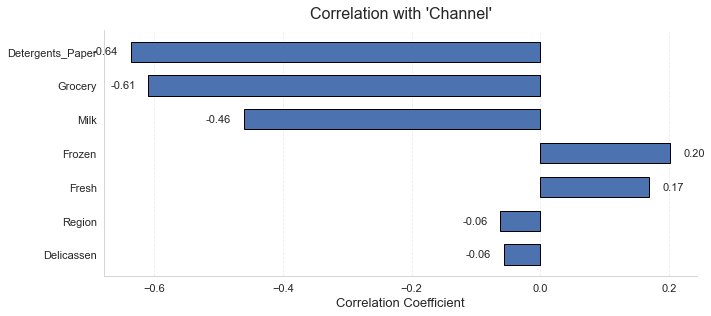

In [ ]:
plot_corr(df)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=None, save_path=None):
    '''
    Plots a styled confusion matrix with annotated counts.

    Parameters:
    - y_true: array-like, true target labels
    - y_pred: array-like, predicted labels
    - labels: optional list of label names (for axis ticks)
    - save_path: optional path to save the figure as PNG
    '''
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Set seaborn style
    sns.set_style("whitegrid", {
        "axes.facecolor": "#eaeaf2",
        "grid.linewidth": 1.2
    })

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot heatmap
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        cbar=False, square=True, linewidths=0.5,
        xticklabels=labels if labels else "auto",
        yticklabels=labels if labels else "auto",
        ax=ax
    )

    # Titles and labels
    ax.set_title("Confusion Matrix", fontsize=16, pad=12)
    ax.set_xlabel("Predicted Labels", fontsize=13)
    ax.set_ylabel("True Labels", fontsize=13)
    ax.tick_params(axis='both', labelsize=12)

    # Adjust layout
    plt.tight_layout()

    # Save if path provided
    if save_path:
        plt.savefig(save_path, format="png", dpi=600)

    # Close and return figure
    plt.close(fig)
    return fig


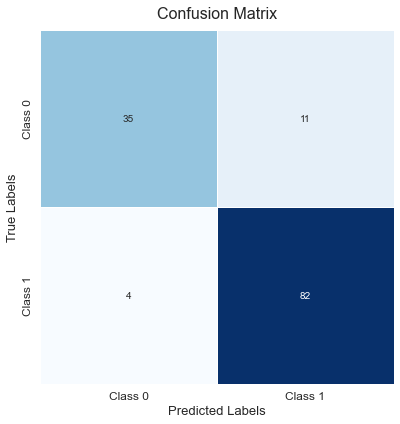

In [ ]:
plot_confusion_matrix(y_test, y_pred, labels=['Class 0', 'Class 1'])

In [ ]:
def plot_feature_importance(model, booster="gbtree", top_n=10, importance_type=None, save_path=None):
    '''
    Plots feature importance for a trained XGBoost model (either Booster or XGBClassifier).
    '''
    if importance_type is None:
        importance_type = "weight" if booster == "gblinear" else "gain"

    # Handle both Booster and XGBClassifier
    if hasattr(model, "get_booster"):
        booster_model = model.get_booster()
    else:
        booster_model = model  # assume it's already a Booster

    # Extract feature importances
    importances = booster_model.get_score(importance_type=importance_type)

    importance_df = pd.DataFrame({
        'Feature': list(importances.keys()),
        'Importance': list(importances.values())
    }).sort_values(by='Importance', ascending=False)

    if top_n:
        importance_df = importance_df.head(top_n)

    sns.set_style("white")
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')

    plt.title(f"Top {top_n} Feature Importances ({importance_type.title()})", fontsize=14)
    plt.xlabel(importance_type.title(), fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')

    fig = plt.gcf()
    plt.close()
    return fig


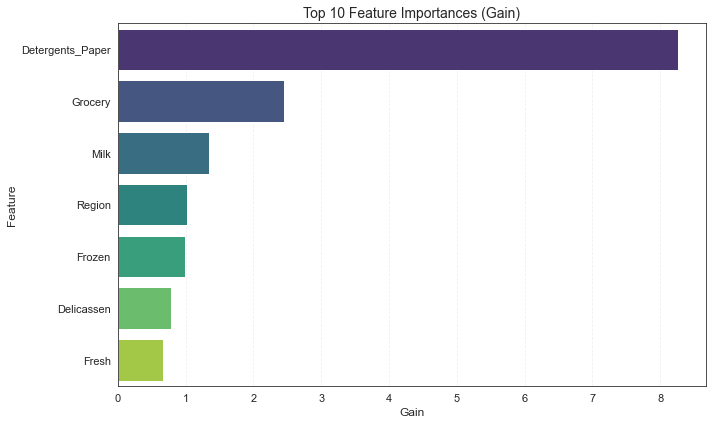

In [ ]:
plot_feature_importance(xgb_clf, booster="gbtree", top_n=10, importance_type=None, save_path=None)

## 🧪 Creating the experiment in MLflow

In [ ]:
# Function to create an MLflow experiment
def create_experiment(experiment_name):
    '''
    Creates an MLflow experiment if it doesn't already exist.
    
    Parameters:
    - experiment_name: string, name of the experiment to create or retrieve
    
    Returns:
    - experiment_id: the ID of the existing or newly created experiment
    '''

    # Check if the experiment already exists by name
    if experiment := mlflow.get_experiment_by_name(experiment_name):
        # If it exists, return its ID
        return experiment.experiment_id
    else:
        # If it doesn't exist, create a new one and return its ID
        return mlflow.create_experiment(experiment_name)

In [ ]:
# creating the experiment
id_experiment = create_experiment('mlflow-project')
print(f'The ID of experiment is: {id_experiment}')

The ID of experiment is: 776306234274517897


View it in your browser: [http://127.0.0.1:8282](http://127.0.0.1:8282)


In [ ]:
# ----------------------------------------------------------
# 1) Split original dataset em treino+validação e teste
# ----------------------------------------------------------
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# Split fixo em treino e validação para todas as trials
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=0)

Quando você faz **hiperparametrização** (como com Optuna), precisa de um conjunto de **validação** além de **treino** e **teste**. Eis o porquê:

1. **Evitar vazamento de informação no teste**

   * Se você só tiver *train* e *test*, e usar o *test* para escolher os melhores hiperparâmetros, você está “vazando” informação — ou seja, acabou otimizando para o *test* em vez de medir a generalização real.
   * O conjunto de **teste** deve permanecer **intocado** até a avaliação final, para simular dados verdadeiramente nunca vistos.

2. **Tuning de hiperparâmetros em um conjunto separado**

   * O **train** ajusta os pesos do modelo.
   * O **validation** serve para **comparar** diferentes configurações (número de árvores, profundidade, learning rate etc.) sem encostar no *test*.
   * Só depois que você escolhe a melhor configuração no *validation* você “congela” o modelo e o avalia no *test*.

3. **Reprodutibilidade entre trials**

   * Ao usar o mesmo *(X\_train, X\_valid)* para **todos** os trials, você garante que a única variação que o Optuna vê é **o hiperparâmetro** — e não uma nova partição dos dados a cada tentativa.
   * Isso torna a comparação entre trials mais justa e estável.

4. **Percentuais típicos**

   * `test_size=0.3` → 30% dos dados vão para o **teste** final.
   * Dos 70% restantes, `test_size=0.2` em relação a esses 70% → 14% do total vira **validação**, sobrando 56% para **treino**.
   * Resumindo:

     * **Treino:** 56%
     * **Validação:** 14%
     * **Teste:** 30%

---

### Fluxo ideal de um pipeline com tuning

1. **Split 3-way**: `train` ↔ `validation` ↔ `test`
2. **Otimização** de hiperparâmetros usando **train+validation**
3. **Treino final** com melhor configuração em **train+validation**
4. **Avaliação final** em **test** (dados nunca vistos)

---

Dessa forma, você garante que:

* O modelo **não se “vicia”** no conjunto de teste.
* A escolha de hiperparâmetros é **realmente generalizável**.
* A avaliação final reflete o desempenho **verdadeiro** em dados novos.


In [ ]:
# ----------------------------------------------------------
# 2) Função de otimização de hiperparâmetros
# ----------------------------------------------------------
def optimize_hyperparameters(trial):
    # Converte para DMatrix
    dsubtrain = xgb.DMatrix(X_train.values, label=y_train.values)
    dvalid   = xgb.DMatrix(X_valid.values, label=y_valid.values)

    # Espaço de busca de hiperparâmetros
    params = {
        'objective':        'binary:logistic',
        'eval_metric':      'logloss',
        'booster':          trial.suggest_categorical('booster', ['gbtree','gblinear','dart']),
        'learning_rate':    trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth':        trial.suggest_int('max_depth', 3, 10),
        'subsample':        trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_lambda':       trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'reg_alpha':        trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
    }

    # Cada trial é um run aninhado no MLflow
    with mlflow.start_run(nested=True):
        model = xgb.train(
            params,
            dsubtrain,
            evals=[(dvalid, 'validation')],
            num_boost_round=1000,
            early_stopping_rounds=20,
            verbose_eval=False
        )

        # Avalia no conjunto de validação
        preds_proba = model.predict(dvalid)
        preds       = (preds_proba >= 0.5).astype(int)
        f1          = f1_score(y_valid, preds)

        # Loga parâmetros e métrica no MLflow
        mlflow.log_params(params)
        mlflow.log_metric('f1_score', f1)

    # Optuna minimiza, então retornamos 1 - f1_score
    return 1.0 - f1

In [ ]:
# ----------------------------------------------------------
# 3) Callback para exibir progresso dos melhores trials
# ----------------------------------------------------------
def f1_score_callback(study, frozen_trial):
    current_winner = study.user_attrs.get('winner', None)
    if study.best_value is not None and current_winner != study.best_value:
        study.set_user_attr('winner', study.best_value)
        print(f'🟢 Novo melhor f1-score: {1.0 - study.best_value:.4f} '
              f'no trial {frozen_trial.number}')

In [ ]:
# ----------------------------------------------------------
# 4) Experimento principal
# ----------------------------------------------------------
run_name = 'experiment_1'
mlflow.set_experiment(experiment_id=id_experiment)

with mlflow.start_run(run_name=run_name):
    # 4.1) Otimização de hiperparâmetros
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize_hyperparameters, n_trials=10, callbacks=[f1_score_callback])

    # Log de tags com melhor trial e f1_score
    mlflow.set_tag('best_f1_score', f'{1.0 - study.best_value:.4f}')
    mlflow.set_tag('best_trial',       str(study.best_trial.number))

    # 4.2) Treino final usando treino+validação completos
    dtrainval = xgb.DMatrix(X_trainval.values, label=y_trainval.values)
    dtest     = xgb.DMatrix(X_test.values,      label=y_test.values)

    final_model = xgb.train(
        study.best_params,
        dtrainval,
        evals=[(dtest, 'test')],
        num_boost_round=1000,
        early_stopping_rounds=20,
        verbose_eval=False
    )

    # 4.3) Avaliação no conjunto de teste
    y_pred_test   = final_model.predict(dtest)
    y_pred_binary = (y_pred_test >= 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred_binary)
    prec = precision_score(y_test, y_pred_binary)
    rec  = recall_score(y_test, y_pred_binary)
    f1   = f1_score(y_test, y_pred_binary)

    mlflow.log_metric('final_accuracy',    acc)
    mlflow.log_metric('final_precision',   prec)
    mlflow.log_metric('final_recall',      rec)
    mlflow.log_metric('final_f1_score',    f1)

    # 4.4) Matriz de confusão
    cm   = confusion_matrix(y_test, y_pred_binary)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')

    fig_path = os.path.join(tempfile.gettempdir(), 'confusion_matrix.png')
    plt.savefig(fig_path)
    mlflow.log_artifact(fig_path)
    plt.close()

    # 4.5) Inferência de assinatura para MLflow Model Registry
    signature = infer_signature(X_trainval, final_model.predict(dtrainval))

    # 4.6) Salvamento do modelo final
    tmp_dir         = tempfile.mkdtemp()
    model_save_path = os.path.join(tmp_dir, 'model')

    mlflow.xgboost.save_model(
        final_model,
        path=model_save_path,
        input_example=X_trainval.iloc[[0]],
        signature=signature,
        model_format='ubj',
        metadata={'model_data_version': 1}
    )
    mlflow.log_artifacts(model_save_path, artifact_path='model')
    shutil.rmtree(tmp_dir)

print('✅ Finalizado. Modelo avaliado corretamente em X_test.')

In [ ]:
def optimize_hyperparameters(trial):
    # Subtreinamento para evitar overfitting
    dsubtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)

    # Hiperparâmetros
    params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
    'max_depth': trial.suggest_int('max_depth', 3, 10),
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
    'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True)}

    with mlflow.start_run(nested=True):
        # Treinamento com early stopping
        model = xgb.train(
            params,
            dsubtrain,
            evals=[(dvalid, "validation")],
            num_boost_round=1000,
            early_stopping_rounds=20,
            verbose_eval=False)

        # Predição na validação
        preds_proba = model.predict(dvalid)
        preds = (preds_proba > 0.5).astype(int)

        # Métrica
        f1 = f1_score(y_valid, preds)

        # Loga no MLflow
        mlflow.log_params(params)
        mlflow.log_metric("f1_score", f1)

    return 1.0 - f1 

## 🚀 Explicação da função `optimize_hyperparameters(trial)`

Essa função é chamada pelo **Optuna** a cada tentativa (`trial`) para:

1. Treinar um modelo XGBoost com os hiperparâmetros sugeridos;
2. Avaliar seu desempenho usando `f1-score` no conjunto de validação;
3. Retornar `1 - f1_score` (porque o Optuna minimiza funções);
4. Registrar os parâmetros e a métrica no **MLflow**.

---

### 🧱 Estrutura principal da função

```python
with mlflow.start_run(nested=True):
    model = xgb.train(
        params,
        dsubtrain,
        evals=[(dvalid, "validation")],
        num_boost_round=1000,
        early_stopping_rounds=20,
        verbose_eval=False
    )

🔍 O que significa with mlflow.start_run(nested=True)?
Inicia uma run aninhada (nested run) no MLflow.

Permite que cada tentativa (trial) do Optuna seja registrada separadamente.

Sem isso, apenas o melhor modelo seria registrado — perdendo o histórico dos testes.

| Parâmetro                        | Explicação                                                   |
| -------------------------------- | ------------------------------------------------------------ |
| `params`                         | Hiperparâmetros fornecidos pelo `trial`                      |
| `dsubtrain`                      | Dados de treino convertidos em `DMatrix`                     |
| `evals=[(dvalid, "validation")]` | Fornece um conjunto de validação para monitorar o desempenho |
| `num_boost_round=1000`           | Número máximo de árvores (boosting rounds)                   |
| `early_stopping_rounds=20`       | Para o treino se a métrica não melhorar em 20 rounds         |
| `verbose_eval=False`             | Suprime o log de progresso durante o treino                  |


✅ Avaliação e Logging

```python
preds_proba = model.predict(dvalid)
preds = (preds_proba >= 0.5).astype(int)
f1 = f1_score(y_valid, preds)

mlflow.log_params(params)
mlflow.log_metric("f1_score", f1)


- O modelo faz previsões no conjunto de validação (X_valid);

- As probabilidades são convertidas em rótulos binários (usando threshold 0.5);

- O f1-score é calculado e logado no MLflow;

- Os hiperparâmetros também são registrados.


optimize_hyperparameters(trial)\
├── define hiperparâmetros via Optuna\
├── inicia sub-run no MLflow (nested)\
│   ├── treina com early stopping usando treino + validação\
│   ├── avalia com f1-score\
│   ├── loga hiperparâmetros e métricas no MLflow\
└── retorna 1 - f1 para ser minimizado pelo Optuna


## 📝 Defining the Logging Callback

Callback registration that notifies when a new trial iteration improves upon the current best result.


In [ ]:
def f1_score_callback(study, frozen_trial):
    current_winner = study.user_attrs.get('winner', None)
    if study.best_value and current_winner != study.best_value:
        study.set_user_attr('winner', study.best_value)
        print(f'Novo melhor f1-score: {1.0 - study.best_value:.4f} no trial {frozen_trial.number}')

🧩 O que é um callback?
No Optuna, callbacks são funções que são chamadas automaticamente após cada trial (tentativa de combinação de hiperparâmetros). Elas permitem que você:

Logue informações extras;

Faça checkpoints;

Interrompa a otimização;

Ou, como aqui, informe quando um novo melhor resultado foi atingido.

```python
def f1_score_callback(study, frozen_trial):


- study: o objeto do Optuna que guarda o histórico da otimização.

- frozen_trial: o trial que acabou de ser executado (não pode mais ser modificado).

``` python
current_winner = study.user_attrs.get("winner", None)


- Recupera quem é o "vencedor atual" da otimização (melhor trial encontrado até agora).

- user_attrs é um dicionário customizável que você pode usar para armazenar coisas no study.

``` python
if study.best_value and current_winner != study.best_value:


- Atualiza o atributo winner com o novo best_value.

``` python
print(f"🟢 Novo melhor f1-score: {1.0 - study.best_value:.4f} no trial {frozen_trial.number}")


- Mostra no console que um novo melhor f1-score foi atingido.

- Lembra que a função objetivo retorna 1 - f1, então o f1 real é 1.0 - study.best_value.

🧠 Resumo funcional


| Função              | Propósito                                                                            |
| ------------------- | ------------------------------------------------------------------------------------ |
| `f1_score_callback` | Monitorar a otimização e imprimir quando um novo melhor `f1-score` for encontrado    |
| Armazena            | O melhor score atual em `study.user_attrs["winner"]`                                 |
| Ajuda a             | Entender o progresso da otimização sem precisar abrir o MLflow ou o Optuna Dashboard |


In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=0)

[I 2025-07-18 14:59:48,349] A new study created in memory with name: no-name-3ed19acb-f457-4e8c-bd07-acf091bff0f6
[I 2025-07-18 14:59:48,883] Trial 0 finished with value: 0.07499999999999996 and parameters: {'booster': 'dart', 'learning_rate': 0.29503875905367116, 'max_depth': 9, 'subsample': 0.7750490334180147, 'colsample_bytree': 0.8236125950754121, 'lambda': 5.672177568474642e-08, 'alpha': 0.051189901364792186}. Best is trial 0 with value: 0.07499999999999996.


🏃 View run salty-loon-919 at: http://127.0.0.1:8282/#/experiments/776306234274517897/runs/0b6271f90da1488b84ca5b27697ec03d
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/776306234274517897
🟢 Novo melhor f1-score: 0.9250 no trial 0


[I 2025-07-18 14:59:49,379] Trial 1 finished with value: 0.07499999999999996 and parameters: {'booster': 'gbtree', 'learning_rate': 0.06914085169920207, 'max_depth': 9, 'subsample': 0.6395729763949977, 'colsample_bytree': 0.6518639806380337, 'lambda': 0.7977672203416196, 'alpha': 0.4219428990918324}. Best is trial 0 with value: 0.07499999999999996.


🏃 View run rumbling-bee-453 at: http://127.0.0.1:8282/#/experiments/776306234274517897/runs/e9ceae53faea45d6807dd050ecf713f6
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/776306234274517897


[I 2025-07-18 14:59:50,199] Trial 2 finished with value: 0.0864197530864198 and parameters: {'booster': 'gbtree', 'learning_rate': 0.02828157449113828, 'max_depth': 7, 'subsample': 0.7308233313377197, 'colsample_bytree': 0.6513058747668055, 'lambda': 0.010972209360366695, 'alpha': 8.781552386721701e-07}. Best is trial 0 with value: 0.07499999999999996.


🏃 View run abrasive-finch-241 at: http://127.0.0.1:8282/#/experiments/776306234274517897/runs/4949359d0edc40eb92cbad574fbbbfaa
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/776306234274517897


[I 2025-07-18 14:59:51,530] Trial 3 finished with value: 0.06329113924050633 and parameters: {'booster': 'dart', 'learning_rate': 0.07938240647467872, 'max_depth': 10, 'subsample': 0.5769940164748641, 'colsample_bytree': 0.9046199102277488, 'lambda': 7.505002623183644e-05, 'alpha': 1.0701186182749086e-05}. Best is trial 3 with value: 0.06329113924050633.


🏃 View run youthful-snipe-641 at: http://127.0.0.1:8282/#/experiments/776306234274517897/runs/be0c112315fd47a5965581a936ba63a9
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/776306234274517897
🟢 Novo melhor f1-score: 0.9367 no trial 3


[I 2025-07-18 14:59:53,430] Trial 4 finished with value: 0.06329113924050633 and parameters: {'booster': 'dart', 'learning_rate': 0.04783061466616363, 'max_depth': 6, 'subsample': 0.7016623151245744, 'colsample_bytree': 0.7818417492808538, 'lambda': 0.00026297118802884675, 'alpha': 0.01289608358201607}. Best is trial 3 with value: 0.06329113924050633.


🏃 View run placid-colt-303 at: http://127.0.0.1:8282/#/experiments/776306234274517897/runs/e245f0123a1e4641b9c008af74928517
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/776306234274517897


[I 2025-07-18 14:59:54,166] Trial 5 finished with value: 0.07317073170731703 and parameters: {'booster': 'gblinear', 'learning_rate': 0.21358043399005888, 'max_depth': 10, 'subsample': 0.7345107738175993, 'colsample_bytree': 0.7121131669875993, 'lambda': 3.601209747715312e-08, 'alpha': 1.920388583640645e-05}. Best is trial 3 with value: 0.06329113924050633.


🏃 View run burly-perch-625 at: http://127.0.0.1:8282/#/experiments/776306234274517897/runs/79d6f6e8ff8642f9a4a5b74c8ab539cb
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/776306234274517897


[I 2025-07-18 14:59:55,214] Trial 6 finished with value: 0.07317073170731703 and parameters: {'booster': 'gblinear', 'learning_rate': 0.025715140918284814, 'max_depth': 8, 'subsample': 0.8662700571731863, 'colsample_bytree': 0.5467001136107104, 'lambda': 2.1419747843254364e-08, 'alpha': 1.1203471648348819e-07}. Best is trial 3 with value: 0.06329113924050633.


🏃 View run secretive-elk-984 at: http://127.0.0.1:8282/#/experiments/776306234274517897/runs/71b3d3c332e5414fa576599258306089
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/776306234274517897


[I 2025-07-18 14:59:55,681] Trial 7 finished with value: 0.07317073170731703 and parameters: {'booster': 'gblinear', 'learning_rate': 0.26140192280490443, 'max_depth': 5, 'subsample': 0.7183821546811774, 'colsample_bytree': 0.9146628723654053, 'lambda': 3.8910336194405396e-05, 'alpha': 0.00038506393770813266}. Best is trial 3 with value: 0.06329113924050633.


🏃 View run painted-gnat-577 at: http://127.0.0.1:8282/#/experiments/776306234274517897/runs/4d5efc3f44a84d23af7e261e94dc067b
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/776306234274517897


[I 2025-07-18 14:59:56,158] Trial 8 finished with value: 0.0864197530864198 and parameters: {'booster': 'gbtree', 'learning_rate': 0.17624921473178265, 'max_depth': 10, 'subsample': 0.6610583978811825, 'colsample_bytree': 0.7126101938720123, 'lambda': 1.7739701074330375e-07, 'alpha': 0.10054082650517407}. Best is trial 3 with value: 0.06329113924050633.


🏃 View run chill-bug-293 at: http://127.0.0.1:8282/#/experiments/776306234274517897/runs/e4dd9a2c4690407f974e9482fe16feed
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/776306234274517897


[I 2025-07-18 14:59:56,740] Trial 9 finished with value: 0.07317073170731703 and parameters: {'booster': 'gblinear', 'learning_rate': 0.2575642790761351, 'max_depth': 5, 'subsample': 0.9237474958512348, 'colsample_bytree': 0.9944970758452387, 'lambda': 4.399926370947282e-07, 'alpha': 8.385186438334403e-08}. Best is trial 3 with value: 0.06329113924050633.


🏃 View run debonair-shark-776 at: http://127.0.0.1:8282/#/experiments/776306234274517897/runs/08366d1860cc4b30b7fdf4d3b5319573
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/776306234274517897


2025/07/18 15:00:08 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\VICTOR~1.FRA\AppData\Local\Temp\tmpbbcc8_mm\model, flavor: xgboost). Fall back to return ['xgboost==2.1.4']. Set logging level to DEBUG to see the full traceback. 


🏃 View run experiment_1 at: http://127.0.0.1:8282/#/experiments/776306234274517897/runs/f8a16a43ff6b48b9ba45258dfeedc0c1
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/776306234274517897
✅ Finalizado. Modelo avaliado corretamente em X_test.


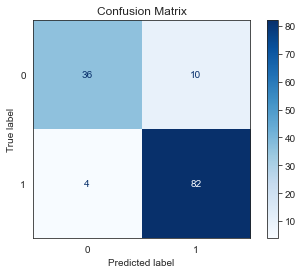

In [ ]:
import math, optuna, mlflow, xgboost as xgb, tempfile, shutil
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, log_loss, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
try:
    from mlflow.models.signature import infer_signature   # MLflow ≤ 3.1
except ImportError:
    from mlflow.models import infer_signature             # MLflow ≥ 3.2

run_name = "experiment_1"
mlflow.set_experiment(experiment_id=id_experiment)

with mlflow.start_run(run_name=run_name):

    # 1) Otimização com Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize_hyperparameters, n_trials=10, callbacks=[f1_score_callback])

    # 2) Treino final com os melhores parâmetros usando train+val
    dtrainval = xgb.DMatrix(X_trainval, label=y_trainval)
    dtest = xgb.DMatrix(X_test, label=y_test)

    final_model = xgb.train(
        study.best_params,
        dtrainval,
        evals=[(dtest, "test")],
        num_boost_round=1000,
        early_stopping_rounds=20,
        verbose_eval=False
    )

    # 3) Avaliação no conjunto de teste (final!)
    y_pred_test = final_model.predict(dtest)
    y_pred_binary = (y_pred_test >= 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred_binary)
    prec = precision_score(y_test, y_pred_binary)
    rec = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)

    mlflow.log_metric("final_accuracy", acc)
    mlflow.log_metric("final_precision", prec)
    mlflow.log_metric("final_recall", rec)
    mlflow.log_metric("final_f1_score", f1)

    # 4) Log figuras
    cm = confusion_matrix(y_test, y_pred_binary)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    fig_path = "confusion_matrix.png"
    plt.savefig(fig_path)
    mlflow.log_artifact(fig_path)

    # 5) Assinatura
    signature = infer_signature(X_trainval, final_model.predict(dtrainval))

    # 6) Salva modelo
    tmp_dir = tempfile.mkdtemp()
    model_save_path = f"{tmp_dir}/model"

    mlflow.xgboost.save_model(
        final_model,
        path=model_save_path,
        input_example=X_trainval.iloc[[0]],
        signature=signature,
        model_format="ubj",
        metadata={"model_data_version": 1}
    )
    mlflow.log_artifacts(model_save_path, artifact_path="model")
    shutil.rmtree(tmp_dir)

print("✅ Finalizado. Modelo avaliado corretamente em X_test.")


In [ ]:
client = MlflowClient()

# Filtra exatamente o run pelo nome
papa = client.search_runs(
    experiment_ids=[id_experiment],
    filter_string='tag.mlflow.runName = "experiment_1"')[0]   # pega o primeiro (deve ser só 1)

run_id_pai = papa.info.run_id
print("RUN pai  :", run_id_pai)
print("URI base :", papa.info.artifact_uri)   # ← URI absoluta exibida na UI

RUN pai  : f8a16a43ff6b48b9ba45258dfeedc0c1
URI base : mlflow-artifacts:/776306234274517897/f8a16a43ff6b48b9ba45258dfeedc0c1/artifacts


In [ ]:
model_uri = f"runs:/{run_id_pai}/model"

# Forma absoluta (equivalente, se preferir copiar/colar da UI)
model_uri_abs = f"{papa.info.artifact_uri}/model/"
model_uri_abs


'mlflow-artifacts:/776306234274517897/f8a16a43ff6b48b9ba45258dfeedc0c1/artifacts/model/'

In [ ]:
import mlflow.xgboost
booster = mlflow.xgboost.load_model(model_uri_abs)   # ou model_uri_abs

# Confere hiperparâmetros (flatten_last)
import json
def flatten_last(d):
    out, stack = {}, [d]
    while stack:
        cur = stack.pop()
        for k, v in cur.items():
            if isinstance(v, dict):
                stack.append(v)
            else:
                out[k] = v          # mantém o último (real)
    return out

flat = flatten_last(json.loads(booster.save_config())["learner"])
for p in ["booster", "max_depth", "eta", "gamma", "reg_lambda", "reg_alpha", "grow_policy"]:
    print(f"{p:11}: {flat.get(p)}")

booster    : dart
max_depth  : 6
eta        : 0.300000012
gamma      : 0
reg_lambda : 1
reg_alpha  : 0
grow_policy: depthwise


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

melhor_modelo = mlflow.xgboost.load_model(model_uri)

Acurácia  : 0.894
Precisão  : 0.891
Revocação : 0.953
F1-score  : 0.921


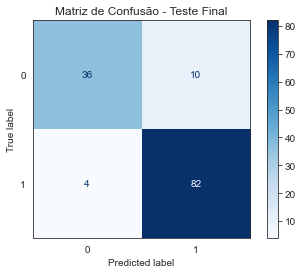

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import mlflow.xgboost
import xgboost as xgb
import matplotlib.pyplot as plt

# ⚠️ Não redivida os dados!
# X_train, X_test, ... já foram definidos antes e X_test deve ser o mesmo da divisão original

# Converte X_test para DMatrix
dtest = xgb.DMatrix(X_test)

# Carrega o modelo treinado
melhor_modelo = mlflow.xgboost.load_model(model_uri)

# Faz predições (probabilidades)
y_prob = melhor_modelo.predict(dtest)

# Aplica threshold de 0.5 para obter classes binárias
y_pred = (y_prob > 0.5).astype(int)

# Calcula as métricas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Exibe os resultados
print(f'Acurácia  : {acc:.3f}')
print(f'Precisão  : {prec:.3f}')
print(f'Revocação : {rec:.3f}')
print(f'F1-score  : {f1:.3f}')

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão - Teste Final")
plt.show()
